# 3D Head and Neck Cancer Tumor Segmentation with Swin UNETR  (BTCV Challenge)

Note 1: This notebook as adapted from the swin-unetr tutorial at https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/swin_unetr_btcv_segmentation_3d.ipynb.

Credits are to:
[1]: Tang, Y., Yang, D., Li, W., Roth, H., Landman, B., Xu, D., Nath, V. and Hatamizadeh, A., 2021. Self-supervised pre-training of swin transformers for 3d medical image analysis. arXiv preprint arXiv:2111.14791.

[2]: Hatamizadeh, A., Nath, V., Tang, Y., Yang, D., Roth, H. and Xu, D., 2022. Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images. arXiv preprint arXiv:2201.01266.

Note 2: The pre-trained Swin UNETR encoder only applies to tasks that involve CT alone. Since we are using PET-CT data, we will train from scratch and use no pre-trained weights.

Note 3: The data for this training were already resampled to the median voxel size of the dataset and normalized. Images were case to float 32 and labels to int8. In the nifti image files CT's are on channel 1 and PET on channel 2. 




## Setup environment

In [1]:
'''
I uncommented the pip install comments below, since I train in a conda environment and on a6000 GPU's, which required another pytorch version that the standard install.
My conda exact conda environment for swin-unetr and running this notebook is in the ./monai-swin-unetr-a6000.txt
'''

#!pip install git+https://github.com/Project-MONAI/MONAI#egg.gitmonai@0.8.1+271.g07de215c 
#!pip install nibabel==3.1.1
#!pip install tqdm==4.63.0


!python -c "import matplotlib" #|| pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

/homes/kovacs/anaconda3/envs/MONAI_dgk1_swin-unetr_a6000/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.0rc1+31.g38b7943a
Numpy version: 1.21.5
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 38b7943a1a48eba702dd1f339bcaf746ef8efbc3
MONAI __file__: /homes/kovacs/anaconda3/envs/MONAI_dgk1_swin-unetr_a6000/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.6.0
gdown version: 4.4.0
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.18.0
mlflow version: 1.26.1
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
os.environ['MONAI_DATA_DIRECTORY'] = '/homes/kovacs/project_data/hnc-auto-contouring/MONAI/'
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/homes/kovacs/project_data/hnc-auto-contouring/MONAI/


## Setup transforms for training and validation
To save on GPU memory utilization, the num_samples can be reduced to 2. 

In [ ]:
num_samples = 4
'''
Note: These parts were uncommented because all data was already resampled to median voxel spacings of data set and data was already normalized:
Spacingd()
ScaleIntensityRanged()
'''
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"), # All my data is saved as LAS
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.9765625, 0.9765625, 2.0),# set to median spacing of dataset
            mode=("bilinear", "nearest"),
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.9765625, 0.9765625, 2.0), # set to median spacing of dataset
            mode=("bilinear", "nearest"),
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)


In [ ]:
data_dir = "/homes/kovacs/project_data/hnc-auto-contouring/MONAI/Task500_HNC01/"
split_JSON = "dataset_0.json"

datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

## Check data shape and visualize

image shape: torch.Size([1, 255, 223, 276]), label shape: torch.Size([1, 255, 223, 276])


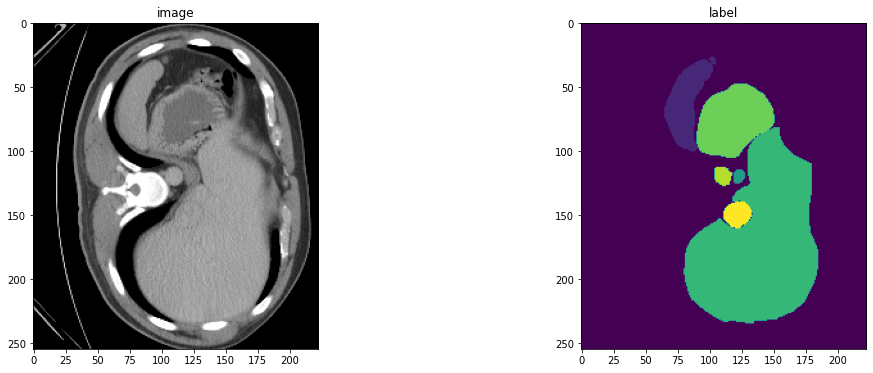

In [6]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Swin UNETR model

In this scetion, we create Swin UNETR model for the 14-class multi-organ segmentation. We use a feature size of 48 which is compatible with self-supervised pre-trained weights. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training. 

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1, #change to 2
    out_channels=14, #change to 1
    feature_size=48,
    use_checkpoint=True,
).to(device)

### Initialize Swin UNETR encoder from self-supervised pre-trained weights

In this section, we intialize the Swin UNETR encoder from weights downloaded from this [link](https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt). If training from scratch is desired, please skip this section.

In [8]:
#weight = torch.load("./model_swinvit.pt")
#model.load_from(weights=weight)
#print("Using pretrained self-supervied Swin UNETR backbone weights !")

Using pretrained self-supervied Swin UNETR backbone weights !


### Optimizer and loss function

In [8]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Execute a typical PyTorch training process

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 30000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

In [10]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.8413 at iteration: 28500


### Plot the loss and metric

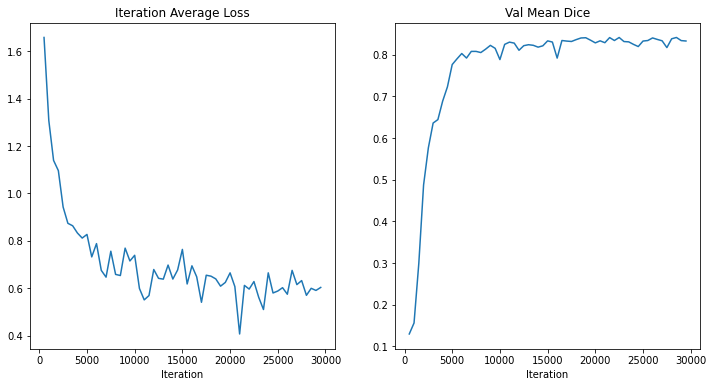

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

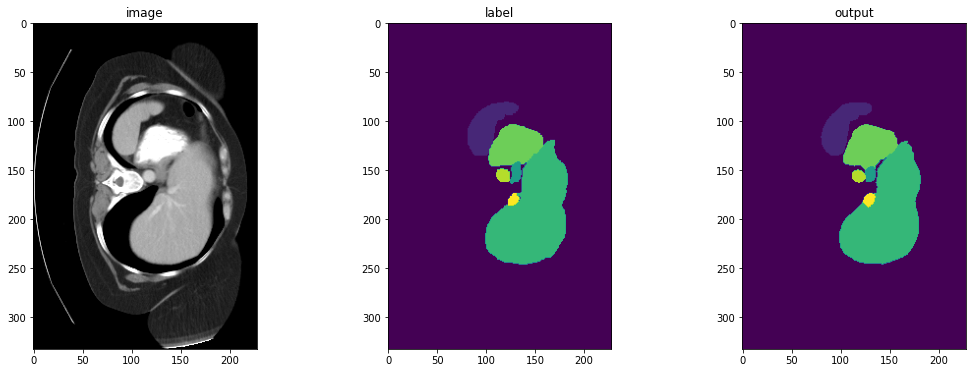

In [12]:
case_num = 4
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]]
    )
    plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [12]:
if directory is None:
    shutil.rmtree(root_dir)